In [1]:
import scanpy as sc
from sklearn.neighbors import NearestNeighbors

# Test simulation code

In [1]:
import os
import argparse

import scanpy as sc
import numpy as np
from sklearn.neighbors import NearestNeighbors


def simulate_tissue(
    n_cells,
    n_neuron_types,
    n_glial_types,
    n_markers,
    snr,
    neuron_glia_ratio,
) -> sc.AnnData:

    # Generate random points within a circle
    r = np.sqrt(np.random.rand(n_cells))
    theta = 2 * np.pi * np.random.rand(n_cells)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    coords = np.vstack((x,y)).T

    # Make regions (one per neuron type)
    regions = np.empty(n_cells, dtype=object)
    increment = 1/n_neuron_types
    region_r_bounds = np.arange(0,1+increment,increment) 
    is_neuron = np.zeros(n_cells) # keep track of which cells are "neurons"
    for i in range(n_neuron_types):
        r_low = region_r_bounds[i]
        r_high = region_r_bounds[i+1]
        in_region = (r_low < r) & (r < r_high)
        for cell in np.where(in_region):
            regions[cell] = str(i) 

    # Split regions into neurons and glia
    is_neuron = np.random.rand(n_cells) < neuron_glia_ratio
    is_glial = ~is_neuron

    # Assign types to neurons
    types = np.empty(n_cells, dtype=object)
    neuron_idxs = np.where(is_neuron)[0]
    for i in neuron_idxs:
        types[i] = regions[i]

    # Assign types to glia
    type_idx = n_neuron_types # prevent overlap w neuron types
    glial_idxs = np.where(is_glial)[0]
    np.random.shuffle(glial_idxs) # shuffle to assign types randomly
    n_per_type = len(glial_idxs) / n_glial_types
    k = 0
    for i in glial_idxs:
        types[i] = str(type_idx)
        k += 1
        if k > n_per_type:
            type_idx += 1
            k = 0

    # Create gene markers for each type
    unique_types = np.unique(types)
    n_types = len(unique_types)
    X = np.zeros((n_cells, n_types, n_markers))
    for i in range(n_types):
        for j in range(n_markers):
            marker = (types==unique_types[i]) + (1/snr) * np.random.rand(n_cells)
            X[:,i,j] = marker
    X = X.reshape(n_cells,-1)

    # Make AnnData object
    adata = sc.AnnData(X)
    adata.obsm['spatial'] = coords
    adata.obs['region'] = regions
    adata.obs['cell_type'] = types
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)

    return adata

In [5]:
n_cells = 5000
n_neuron_types = 4
n_glial_types = 8
n_markers = 10
snr = 0.5
neuron_glia_ratio = 0.5
random_seed = 0

In [6]:
np.random.seed(random_seed)
adata = simulate_tissue(
    n_cells,
    n_neuron_types,
    n_glial_types,
    n_markers,
    snr,
    neuron_glia_ratio,
)

In [7]:
adata

AnnData object with n_obs × n_vars = 5000 × 120
    obs: 'region', 'cell_type'
    var: 'mean', 'std'
    uns: 'log1p'
    obsm: 'spatial'

# Load and format

In [4]:
adata = sc.read_h5ad('/stanley/WangLab/kamal/data/projects/spin/reviews/simulation/adata.h5ad')

In [ ]:
# adata.obs['region_true'] = adata.obs['region']
# del adata.obs['region']

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


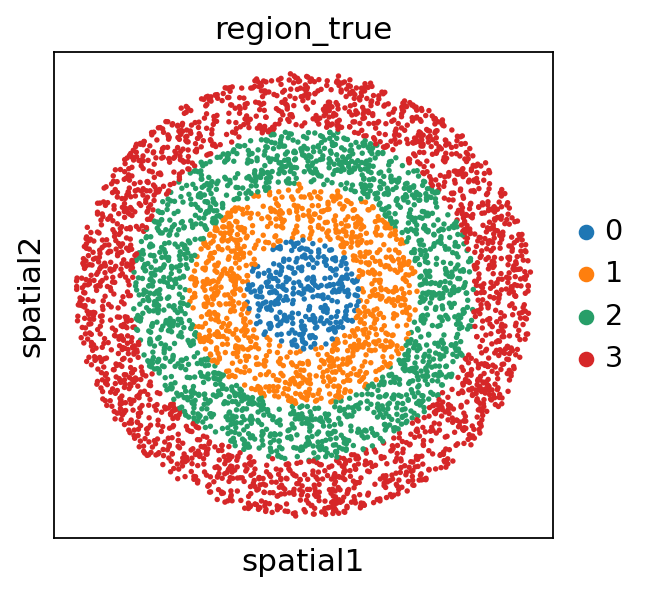

In [9]:
sc.set_figure_params(figsize=(4,4))
sc.pl.embedding(adata, basis='spatial', color='region_true')

In [7]:
k = 50
nbrs = NearestNeighbors(n_neighbors=k).fit(adata.obsm['spatial'])
A = nbrs.kneighbors_graph()
adata.obsp['spatial_connectivities'] = A.copy()

In [8]:
adata.write('/stanley/WangLab/kamal/data/projects/spin/reviews/simulation/adata.h5ad')